# General Setup

- Import Libraries
- Set constants
- Setup RNG
- Setup HW connection

In [1]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import numpy as np

/home/nico/miniconda3/envs/simon/lib/python3.13/site-packages/chipwhisperer/capture/trace/TraceWhisperer.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources # type: ignore


In [30]:
rng = np.random.default_rng()

NUM_MEASUREMENTS = 10000

In [3]:
scope = cw.scope()
target = cw.target(scope, cw.targets.SimpleSerial)
scope.default_setup()

scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 13058138                  to 53663668                 
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.clkgen_div                   changed from 1                         to 26                       
scope.clock.clkgen_freq                  changed from 192000000.0               to 7384615.384615385        
scope.io.tio1      

# Compile C Code

In [4]:
%%bash
cd ../chipwhisperer/firmware/mcu/simpleserial-simon/
make PLATFORM=CWLITEARM CRYPTO_TARGET=SIMON CRYPTO_OPTIONS=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:13.2.rel1-2) 13.2.1 20231009
Copyright (C) 2023 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWLITEARM 
.
Compiling:
-en     simpleserial-simon.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_hal_lowlevel.c ...
-e Done!
.
Compiling:
-en     .././hal//stm32f3/stm32f3_sysmem.c ...
-e Done!
.
Compiling:
-en     .././crypto/simon64_128.c ...
-e Done!
.
Assembling: .././hal//stm32f3/stm32f3_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-se

# Reconnect in case of Error

In [14]:
"""
scope.dis()
target.dis()
scope = cw.scope()
target = cw.target(scope, cw.targets.SimpleSerial)
scope.default_setup()
"""

'\nscope.dis()\ntarget.dis()\nscope = cw.scope()\ntarget = cw.target(scope, cw.targets.SimpleSerial)\nscope.default_setup()\n'

# Program Target

In [6]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, "../chipwhisperer/firmware/mcu/simpleserial-simon/simpleserial-simon-CWLITEARM.hex")

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 4971 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4971 bytes


# Verify Implementation by using Test Vector

In [7]:
key = bytearray([0x1B, 0x1A, 0x19, 0x18, 0x13, 0x12, 0x11, 0x10, 0x0B, 0x0A, 0x09, 0x08, 0x03, 0x02, 0x01, 0x00])
pt = bytearray([0x65, 0x6B, 0x69, 0x6C, 0x20, 0x64, 0x6E, 0x75])
ct_expect = bytearray([0x44, 0xC8, 0xFC, 0x20, 0xB9, 0xDF, 0xA0, 0x7A])

target.simpleserial_write('k', key)
target.simpleserial_wait_ack()

target.simpleserial_write('p', pt)
ct: bytearray = target.simpleserial_read('r', 8)

print("Ciphertext: {}".format(ct.hex()))
if ct == ct_expect:
    print("Ciphertext matches expected value.")
else:

    raise ValueError("Ciphertext does not match expected value!")

Ciphertext: 44c8fc20b9dfa07a
Ciphertext matches expected value.


# Perform Measurements

In [31]:
project = cw.create_project("simon_measurement_plain", overwrite=True)
# key = bytearray(rng.integers(0, 2**32, 4, dtype=np.uint32))
print(key.hex())

1901366086de7696d0427aff738dd98a


In [ ]:
target.output_len = 8

for i in range(NUM_MEASUREMENTS):
    pt = bytearray(rng.integers(0, 2**32, 2, dtype=np.uint32))
    trace = cw.capture_trace(scope, target, pt, key, as_int=True)
    project.traces.append(trace)


'/home/nico/git/impl-attck/simon/traces/02_simon_plain_10000/trace.zip'

In [ ]:
project.save()
project.export("./traces/02_simon_plain_10000/trace.zip")

'/home/nico/git/impl-attck/simon/simon_measurement_plain.zip'

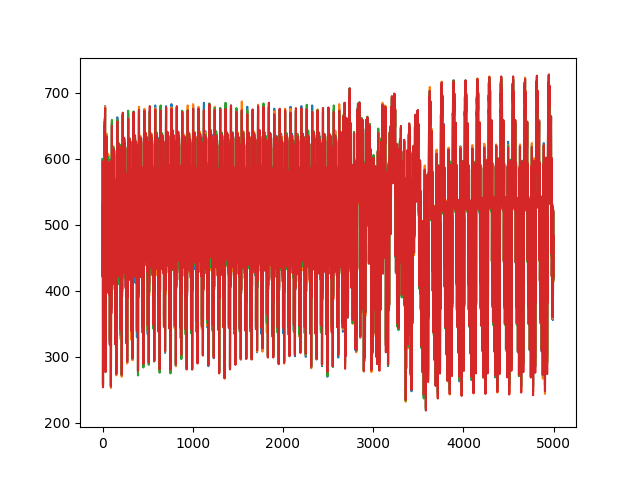

In [33]:

%matplotlib widget
# enable interactive plotting in the notebook

plt.figure()
plt.plot(project.traces[0].wave)
plt.plot(project.traces[1].wave)
plt.plot(project.traces[2].wave)
plt.plot(project.traces[3].wave)
plt.show()